# Linear Regression

Just as naive Bayes is a good starting point for classification tasks, linear regressions models are a good starting point for regression tasks. Such models are popular because they can fit very quickly and are very interpretable. The simplest form of a linear regression model is fitting a straight line to data, but such models can be extended to model much more complicated behavior.

In this section we will walk-through the mathematic behind this well-known problem, before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

A straight-line fit is a model of the form

$$
y = ax + b
$$

where $a$ is commonly known as the _slope_, and $b$ is commonly known as the _intercept_.

Consider the following data:

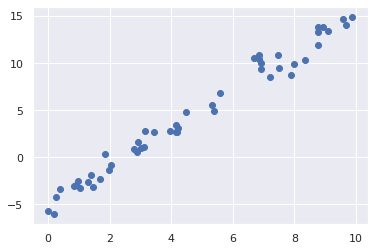

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's `LinearRegression` estimator ti fit this data and construct the best-fit line:

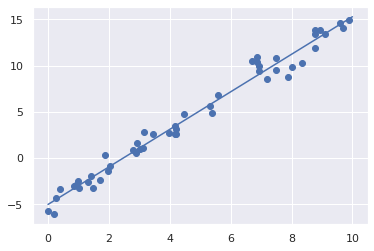

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters `coef_` and `intercept_`, respectively:

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


We can see that the results are very close to the inputs (slope of 2 and intercept of -5).

However, the `LinearRegression` estimator is much more capable than this: in addition to simple straight-lines fits, it can also handle multidimensional models of the form:

$$
y = a_0 + a_1 x_1 + a_2 x_2 + ...
$$

Geometrically, this is similar to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can still see one of these fits in action by building some example data:

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.50000000000001
[ 1.5 -2.   1. ]


We can see that the linear regression recovers the coefficients used to construct the data. In this way, we can use the single `LinearRegression` estimators to fit lines, planes or hyperplanes to our data. It still looks like this approach is limited strictly by linear relationships between variables, but we can relax this as well.

## Basis Function Regression

One trick we can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to _basis functions_. The idea is to take our multidimensional linear model:

$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + ...
$$

and build the $x_1, x_2, x_3$, and so on, from our single-dimensional input $x$. That is, we let $x_n = f_n(x)$, where $f_n()$ is some functions that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + ...
$$

Notice that this is _still a linear model_: the linearity refers to the fact the the coefficients $a_n$ never multiply or divide each other. What we have done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

The polynomial projection is built into Scikit-Learn via the `PolynomialFeatures` transformer:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We can see that our one-dimensional array has been transformed into a three-dimensional array by taking the exponent of each value. This higher dimensional data can then be plugged into a linear regression.

For example, we can make a 7th-degree model using a pipeline in this way:

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can fit the linear model to much more complicated relationships between variables. For example, here is a sine wave with some noise:

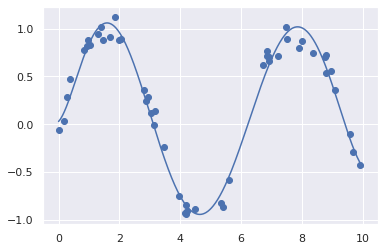

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Through the use of 7th-order polynomial basis functions, our linear model can provide an excellent fit to this non-linear data!

### Gaussian basis functions

We are not limited to only polynomial basis functions. For example, another useful pattern is to fit a model that is a sum of Gaussian bases. The result might look something like the following:

![Gaussian basis](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.06-gaussian-basis.png)

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here:

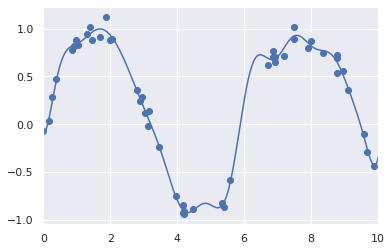

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

This example is here just to make clear that there is not special about polynomial basis functions: if we think one basis or another might be appropriate, we can just as well use them.

## Regularization

The introduction of basis functions into linear regression makes models much more flexible, but it can also very quickly lead to over-fitting. For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

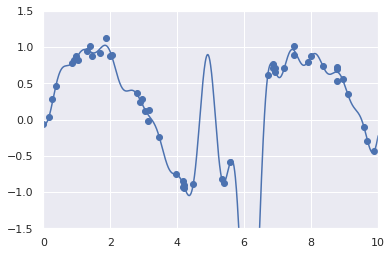

In [10]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

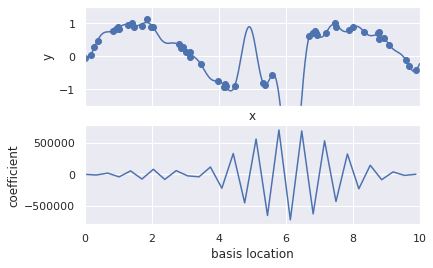

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

This lower panel of this figure shoes the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We already know that such behavior is problematic, so it would be nice if we could limit such spikes explicitly in the model by penalizing large values of the model parameters. Turns out that such a penalty is known as _regularization_, and comes in several forms.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as _ridge regression_ or $L_2$ _regularization_, sometimes also called _Tikhonov regularization_. This form of regularization penalizes the sum of squares (2-norms) of the model coefficients. In this case, the penalty on the model fit would be

$$
P = \alpha \sum_{n=1}^N \theta_n^2
$$

where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the `Ridge` estimator:

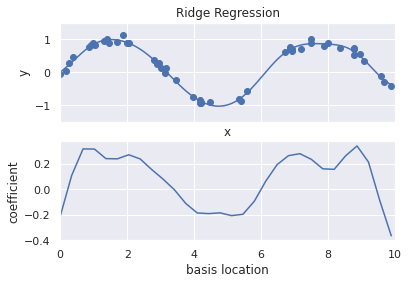

In [12]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter essentially controls the complexity of the resulting model. In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed. Ridge regression in particular has the advantage of being computed very efficiently, at hardly more computational cost than the original linear regression model.

## Lasso regression ($L_1$ regularization)

The lasso regularization is another very common type of regularization, and involved penalizing the sum of absolute values (1-norms) of regression coefficients:

$$
P = \alpha \sum_{n=1}^N |\theta_n|
$$

Though this is conceptually similar to ridge regression, the results can differ significantly: for example, due to geometric reasons lasso regression tends to favor _sparse models_ where possible, which means that it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure using L1-normalized coefficients:

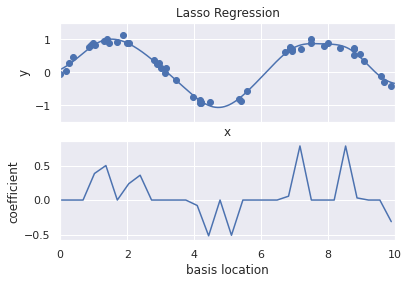

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.002))
basis_plot(model, title='Lasso Regression')

With the lasso regression, many of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined, for example, via cross-validation.

## Example: Predicting Bicycle Traffic

As an example, we'll take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season and other factors. For this, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors affect the volume of bicycle traffic through this corridor. 

We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any of these parameters affects the number of riders on a given day.

This is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning. This is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [14]:
import pandas as pd
counts = pd.read_csv('../data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('../data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

Next we will compute the total daily bicycle traffic, and store this in its own `DataFrame`:

In [15]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

The patterns of use generally vary from day to day. We will account for this in our data by adding binary columns that indicate the day of the week:

In [16]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we can expect riders to behave differently on holidays. Let's add an indicator of this as well:

In [17]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight can have an impact as well. We will use the standard astronomical calculation to add this information:

(8.0, 17.0)

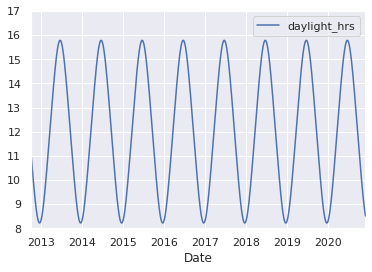

In [18]:
from datetime import datetime
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also consider the average temperature and total precipitation and add it to the data. Let's also add a flag that indicates whether a day is dry (has zero precipitation):

In [19]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, we will add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [20]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

With everything in order, we can take a look at our data:

In [21]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose which columns to use and fit a linear regression model to our data. We set `fit_intercept=False` because the daily flags essentially operate as their own day-specific intercepts:

In [22]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

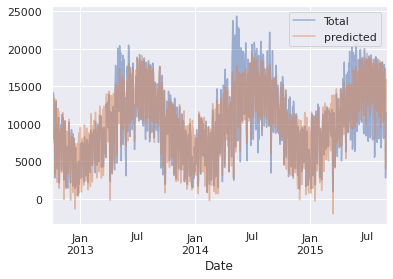

In [23]:
daily[['Total', 'predicted']].plot(alpha=0.5);

We can see that we have missed some features (maybe the features are not complete, or perhaps there are some nonlinear relationships that we did not take into account), but the overall approximation is enough to give us some insights. We can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [24]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             2019.531023
Tue             2440.935744
Wed             2370.694566
Thu             1929.432461
Fri              711.921382
Sat            -4413.206842
Sun            -4534.268983
holiday        -4749.605523
daylight_hrs     515.406045
PRCP           -2659.339527
dry day         2190.794369
Temp (C)         260.651164
annual           107.770852
dtype: float64

These numbers are easier to interpret with some measure of their uncertainty. We can compute such uncertainties quickly using bootstrap resamplings of the data:

In [25]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimates, let's again look at the results:

In [26]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           2020.0  345.0
Tue           2441.0  333.0
Wed           2371.0  331.0
Thu           1929.0  341.0
Fri            712.0  324.0
Sat          -4413.0  318.0
Sun          -4534.0  332.0
holiday      -4750.0  653.0
daylight_hrs   515.0   36.0
PRCP         -2659.0  249.0
dry day       2191.0  133.0
Temp (C)       261.0   14.0
annual         108.0   71.0


We can see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. We see that for each additional hour of daylight, 515 $\pm$ 36 more people choose to ride and a temperature increase of one degree Celsius encourages 261 $\pm$ 14 people to ride, for example.

Our model is almost certainly missing some relevant information. For example. nonlinear effects (such as effects of precipitation _and_ cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, some finer-grained information have been thrown away, such as the difference between a rainy morning and a rainy afternoon, or the possible effects of a rainy Tuesday on Wednesday's numbers. These are all potentially interesting effects that we now have the tools to begin exploring.